In [1]:
#import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython import display
from mlxtend.data import loadlocal_mnist
import time
import pandas as pd
display.set_matplotlib_formats('svg')

/Users/xiongxiaoxue/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2853838097.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
torch.__version__

'1.12.1'

### 1. only runtime
2.same dataset

layer 1 input+output
layer 2 input hidden output



activation function don't change:relu
number of layers: 2 4 6 8 10
nodes 4*0.5=2 4*1.5=6 4*2.5=10 14 18
learning algorithm don't change ADAM
remove regularization
lr 10-4 10-3 10-2 10-1 0
batch size 8 16 32 64 128
stopping criteria train accuracy not change training loss is low

#要不要验证集?

# import and process data

In [3]:
#import data
train_data, train_label=loadlocal_mnist(images_path="MNIST/train-images.idx3-ubyte",
                                        labels_path="MNIST/train-labels.idx1-ubyte")
test_data, test_label=loadlocal_mnist(images_path="MNIST/t10k-images.idx3-ubyte",
                                        labels_path="MNIST/t10k-labels.idx1-ubyte")

In [4]:
np.max(train_data)

255

In [5]:
Ns=train_data.shape[0]
Ni=train_data.shape[1]
N0=10

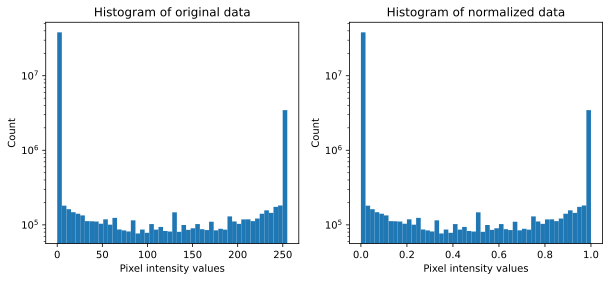

In [6]:
#normalize the data to [0,1]
trainNorm=train_data/np.max(train_data)
testNorm=test_data/np.max(test_data)

fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(train_data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(trainNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

# Convert data

In [7]:
# convert to tensor
train_dataT=torch.tensor(trainNorm).float()
train_labelT=torch.tensor(train_label).long()
test_dataT=torch.tensor(testNorm).float()
test_labelT=torch.tensor(test_label).long()

# convert into PyTorch Datasets
train_data=TensorDataset(train_dataT,train_labelT)
test_data=TensorDataset(test_dataT,test_labelT)


In [8]:
# check all variables
%whos

Variable           Type             Data/Info
---------------------------------------------
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
N0                 int              10
Ni                 int              784
Ns                 int              60000
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                 ndarray          2: 2 elems, type `object`, 16 bytes
display            module           <module 'IPython.display'<...>ages/IPython/display.py'>
fig                Figure           Figure(1000x400)
loadlocal_mnist    function         <function loadlocal_mnist at 0x145f340d0>
nn                 module           <module 'torch.nn' from '<...>es/torch/nn/__init__.py'>
np                 module           <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
pd                 module           <module 'p

# Create FFN model

number of layers: 2 4 6 8 10

nodes 4*0.5=2 4*1.5=6 4*2.5=10 14 18
lr 10-4 10-3 10-2 10-1 0
batch size 8 16 32 64 128
stopping criteria train accuracy not change training loss is low

###  10 layers (input hidden*9 output)

In [9]:
# create a class for the model
def createFFN(nodes,lr):
    class ffNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            ###input layer
            self.input=nn.Linear(784,nodes)
            
            ###hidden layer
            self.fc1=nn.Linear(nodes,nodes)
            self.fc2=nn.Linear(nodes,nodes)
            self.fc3=nn.Linear(nodes,nodes)
            self.fc4=nn.Linear(nodes,nodes)
            self.fc5=nn.Linear(nodes,nodes)
            self.fc6=nn.Linear(nodes,nodes)
            self.fc7=nn.Linear(nodes,nodes)
            self.fc8=nn.Linear(nodes,nodes)
            self.fc9=nn.Linear(nodes,nodes)

            nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc5.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc6.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc7.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc8.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc9.weight, mode='fan_in', nonlinearity='relu')

            
            ###output layer
            self.output=nn.Linear(nodes,10)
            
            nn.init.kaiming_uniform_(self.output.weight, mode='fan_in', nonlinearity='relu')
            
            
        #forward pass
        def forward(self,x):
            x=F.relu(self.input(x))
            x=F.relu(self.fc1(x))
            x=F.relu(self.fc2(x))
            x=F.relu(self.fc3(x))
            x=F.relu(self.fc4(x))
            x=F.relu(self.fc5(x))
            x=F.relu(self.fc6(x))
            x=F.relu(self.fc7(x))
            x=F.relu(self.fc8(x))
            x=F.relu(self.fc9(x))
            return torch.softmax(self.output(x),dim=1)
            # rawoutput with CrossEntoryLoss
    
    #create the model instance
    net=ffNet()
    
    #loss function
    lossfun=nn.CrossEntropyLoss() 
    
    #optimizer
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    
    return net,lossfun,optimizer

In [10]:
# translate into dataloader objects
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# test the model with one batch
net,lossfun,optimizer=createFFN(nodes=2,lr=0.0001)

X,y=next(iter(train_loader))
yHat=net(X)

#values are log-probability of each number (0-9)
print(yHat)
#print(yHat.shape)

#Now compute the loss
loss=lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

tensor([[0.0537, 0.0814, 0.1187, 0.0998, 0.1688, 0.0902, 0.1512, 0.0607, 0.0770,
         0.0985],
        [0.0538, 0.0816, 0.1186, 0.0997, 0.1685, 0.0900, 0.1515, 0.0607, 0.0770,
         0.0987],
        [0.0540, 0.0820, 0.1184, 0.0994, 0.1677, 0.0895, 0.1520, 0.0607, 0.0771,
         0.0992],
        [0.0537, 0.0813, 0.1187, 0.0998, 0.1689, 0.0903, 0.1511, 0.0607, 0.0769,
         0.0984],
        [0.0540, 0.0820, 0.1184, 0.0994, 0.1677, 0.0895, 0.1520, 0.0607, 0.0771,
         0.0992],
        [0.0540, 0.0820, 0.1184, 0.0994, 0.1677, 0.0895, 0.1520, 0.0607, 0.0771,
         0.0992],
        [0.0538, 0.0815, 0.1186, 0.0997, 0.1686, 0.0901, 0.1513, 0.0607, 0.0770,
         0.0986],
        [0.0537, 0.0813, 0.1187, 0.0998, 0.1689, 0.0903, 0.1511, 0.0607, 0.0769,
         0.0984],
        [0.0538, 0.0816, 0.1186, 0.0996, 0.1684, 0.0899, 0.1515, 0.0607, 0.0770,
         0.0988],
        [0.0540, 0.0820, 0.1184, 0.0994, 0.1677, 0.0895, 0.1520, 0.0607, 0.0771,
         0.0992],
        [0

# Create train function

In [11]:
# translate into dataloader objects
# batchsize=32
# train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
# test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# #number of epochs
# numepochs=60

# #create a new model
# net,lossfun,optimizer=createFFN(2,0.0001)

# #initialize losses
# losses=torch.zeros(numepochs)
# trainAcc=[]
# testAcc=[]
# trian function

def trainfunction():
        
    #loop over epochs
    for epochi in range(numepochs):

        #loop over training data batches
        batchAcc=[]
        batchLoss=[]
        for X,y in train_loader:

            #forward pass and loss
            yHat=net(X)
            loss=lossfun(yHat,y)

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches=torch.argmax(yHat,dim=1)==y #booleans(flase/true)
            matchesNumeric=matches.float()       #convert to numbers (0/1)
            accuracyPct=100*torch.mean(matchesNumeric)# average and *100
            batchAcc.append(accuracyPct)         #add to list of accuracies

        #now after training through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi]=np.mean(batchLoss)

        #test accuracy
        X,y=next(iter(test_loader)) #extract X,y from test dataloader
        yHat=net(X)

        #compare the following really long line of code to the training accuracy lines
        testAcc.append(100*torch.mean((torch.argmax(yHat,dim=1)==y).float()))

    return trainAcc,testAcc,losses,net


# Run the model

In [12]:
start = time.perf_counter()
trainAcc,testAcc,losses,net=trainfunction(2,0.00001)
end = time.perf_counter()

In [14]:
end-start

449.3218982

In [15]:
#losses

In [35]:
layer=3
fig,ax=plt.subplots(1,2,figsize=(16,5))

ax[0].plot(np.array(losses))
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy:{testAcc[-1]:.2f}%')
ax[1].legend()

# plt.show()
plt.savefig(f"./image/pic_layer_{layer}_nodes_{nodes}_batch_{batch}_lr_{lr}.jpg")
plt.close()

# Collect Data

In [13]:
# nodes 4*0.5=2 4*1.5=6 4*2.5=10 14 18
# lr 10-4 10-3 10-2 10-1 0
# batch size 8 16 32 64 128
nodes_ls=[2,4,8,16,32]
# for alpha in range(2,11):
#     nodes_ls.append(int(Ns/(alpha*(Ni+N0))))

# nodes_ls=list(set(nodes_ls))

In [15]:
numepochs=300
layer=10
lr=0.001
df=pd.DataFrame()
for nodes in nodes_ls:
#     for lr in [0.0001,0.001,0.01,0.1,0]:
    for batch in [8,16,32,64,128]:
        # translate into dataloader objects
        batchsize=batch
        train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
        test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


        #create a new model
        net,lossfun,optimizer=createFFN(nodes,lr)

        #initialize losses
        losses=torch.zeros(numepochs)
        trainAcc=[]
        testAcc=[]
        # trian function

        start = time.perf_counter()
        trainAcc,testAcc,losses,net=trainfunction()
        end = time.perf_counter()

        runtime=end-start

        temp=pd.DataFrame(columns=['layer','nodes','lr','batch','runtime','trainAcc','testAcc'],data=[[layer,nodes,lr,batch,runtime,trainAcc[-1],testAcc[-1]]])

        df=df.append(temp)

#         fig,ax=plt.subplots(1,2,figsize=(16,5))

#         ax[0].plot(np.array(losses))
#         ax[0].set_xlabel('Epochs')
#         ax[0].set_ylabel('Loss')
#         ax[0].set_ylim([0,3])
#         ax[0].set_title('Model loss')

#         ax[1].plot(trainAcc,label='Train')
#         ax[1].plot(testAcc,label='Test')
#         ax[1].set_xlabel('Epochs')
#         ax[1].set_ylabel('Accuracy (%)')
#         ax[1].set_ylim([10,100])
#         ax[1].set_title(f'Final model test accuracy:{testAcc[-1]:.2f}%')
#         ax[1].legend()

#         # plt.show()
#         plt.savefig(f"./image/pic_layer_{layer}_nodes_{nodes}_batch_{batch}_lr_{lr}.jpg")
#         plt.close()
        print(f"layer:{layer} nodes:{nodes} done")

df.to_csv(f"output2_layer_{layer}.csv")

/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:2 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:2 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:2 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:2 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:2 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:4 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:4 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:4 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:4 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:4 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:8 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:8 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:8 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:8 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:8 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:16 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:16 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:16 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:16 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:16 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:32 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:32 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:32 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


layer:10 nodes:32 done
layer:10 nodes:32 done


/var/folders/pm/w4n07xw134ngfqypr7l51kw00000gn/T/ipykernel_1640/2148966023.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(temp)


In [16]:
df

,layer,nodes,lr,batch,runtime,trainAcc,testAcc
0,10,2,0.001,8,1941.122103,11.236667,tensor(11.3500)
0,10,2,0.001,16,1029.473609,11.236667,tensor(11.3500)
0,10,2,0.001,32,591.434124,11.236667,tensor(11.3500)
0,10,2,0.001,64,372.035307,11.235992,tensor(11.3500)
0,10,2,0.001,128,258.625347,44.935230,tensor(44.1000)
0,10,4,0.001,8,2223.411844,9.915000,tensor(10.0900)
0,10,4,0.001,16,1069.327742,59.128334,tensor(59.1400)
0,10,4,0.001,32,606.206554,48.431667,tensor(48.8500)
0,10,4,0.001,64,377.438523,63.780682,tensor(61.7200)
0,10,4,0.001,128,1313.604678,62.164463,tensor(62.0100)


In [15]:
df.to_csv(f"output_layer_{layer}.csv")

In [18]:
nodes_ls

[2, 37, 6, 7, 8, 9, 10, 12, 14, 15, 18, 25]

In [19]:
df

,layer,nodes,lr,batch,runtime
0,10,2,0.0001,8,4136.775401
0,10,2,0.0001,16,2312.794917
0,10,2,0.0001,32,1202.096080
0,10,2,0.0001,64,681.648057
0,10,2,0.0001,128,465.352290
0,10,2,0.0010,8,4279.248130
0,10,2,0.0010,16,2283.604423
0,10,2,0.0010,32,1182.386172
0,10,2,0.0010,64,740.864426
0,10,2,0.0010,128,465.005861
